<a href="https://colab.research.google.com/github/kranthi7745/kranthi/blob/main/car_number_plate_detection_14_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [2]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://download.pytorch.org/whl/cu117


In [3]:
!pip install easyocr

In [4]:
!pip install imutils

In [5]:
!pip install opencv-python-headless==4.8.0.74

In [6]:
from pathlib import Path
import shutil
from bs4 import BeautifulSoup
import os

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
import os
import shutil
from tqdm import tqdm
import yaml
import matplotlib.pyplot as plt
import torch
import cv2
%matplotlib inline

In [8]:
!pip install -q kaggle


In [9]:
#to upload the json file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kranthikumar7745","key":"7242d24e4caccec85377ac1cd87fbe72"}'}

In [10]:
#create kaggle folder
! /mkdir~/.kaggle

/bin/bash: line 1: /mkdir~/.kaggle: No such file or directory


In [11]:
!kaggle kernels pull matthewkoltunov/license-plate-detection

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [12]:
filenames = []

size_props = {
    'height':[],
    'width':[]
}

bounding_box_props = {
    'xmin':[],
    'ymin':[],
    'xmax':[],
    'ymax':[]
}

In [17]:
import zipfile
with zipfile.ZipFile('archive (2).zip','r') as zip_ref:
  zip_ref.extractall()

In [18]:
annotations_path = '/content/annotations'
for file in tqdm(os.listdir(annotations_path)):
    annotation = ET.parse(os.path.join(annotations_path, file))
    filenames.append(os.path.join(annotations_path, file))
    size = annotation.find('size')
    for name, prop_list in size_props.items():
        prop_value = size.find(name).text
        size_props[name].append(int(prop_value))
    bounding_box = annotation.find('object').find('bndbox')
    for name, prop_list in bounding_box_props.items():
        prop_value = bounding_box.find(name).text
        bounding_box_props[name].append(int(prop_value))

100%|██████████| 433/433 [00:00<00:00, 12362.56it/s]


In [19]:
df = pd.DataFrame({
    'file':filenames,
    'width':size_props['width'],
    'height':size_props['height'],
    'xmin':bounding_box_props['xmin'],
    'ymin':bounding_box_props['ymin'],
    'xmax':bounding_box_props['xmax'],
    'ymax':bounding_box_props['ymax']
})

In [20]:
df.head()

,file,width,height,xmin,ymin,xmax,ymax
0,/content/annotations/Cars165.xml,590,343,209,217,293,254
1,/content/annotations/Cars189.xml,435,290,285,241,423,286
2,/content/annotations/Cars127.xml,400,267,360,166,383,181
3,/content/annotations/Cars356.xml,550,367,241,216,364,275
4,/content/annotations/Cars423.xml,400,250,162,159,283,183


In [21]:
df['center_x'] = (df['xmax'] + df['xmin'])/(2*df['width'])
df['center_y'] = (df['ymax'] + df['ymin'])/(2*df['height'])

df['bb_width'] = (df['xmax'] - df['xmin'])/df['width']
df['bb_height'] = (df['ymax'] - df['ymin'])/df['height']

In [22]:
df.head()

,file,width,height,xmin,ymin,xmax,ymax,center_x,center_y,bb_width,bb_height
0,/content/annotations/Cars165.xml,590,343,209,217,293,254,0.425424,0.686589,0.142373,0.107872
1,/content/annotations/Cars189.xml,435,290,285,241,423,286,0.813793,0.908621,0.317241,0.155172
2,/content/annotations/Cars127.xml,400,267,360,166,383,181,0.928750,0.649813,0.057500,0.056180
3,/content/annotations/Cars356.xml,550,367,241,216,364,275,0.550000,0.668937,0.223636,0.160763
4,/content/annotations/Cars423.xml,400,250,162,159,283,183,0.556250,0.684000,0.302500,0.096000


In [23]:
yolo_df = df[['file', 'center_x', 'center_y', 'bb_width', 'bb_height']]
# Performing 70-15-15 split
test_size = int(0.15 * len(df))

df_train, df_test = train_test_split(yolo_df, test_size=test_size, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=test_size, random_state=42)

In [24]:
train_path = os.path.join('Images', 'train')
val_path = os.path.join('Images','val')
test_path = os.path.join('Images', 'test')
images_path = '/content/images'

if not os.path.exists(train_path):
    os.makedirs(train_path)
    print('Made folder for train set')

if not os.path.exists(val_path):
    os.makedirs(val_path)
    print('Made folder for val set')

if not os.path.exists(test_path):
    os.makedirs(test_path)
    print('Made folder for test set')

Made folder for train set
Made folder for val set
Made folder for test set


In [25]:
print('Moving images for train set')
for _, row  in tqdm(df_train.iterrows()):
    annotation_path = row['file']
    image_name = os.path.split(annotation_path)[-1].replace('.xml','')
    image_src = os.path.join(images_path, f'{image_name}.png')
    image_dst = os.path.join(train_path, f'{image_name}.png')
    shutil.copy2(image_src, image_dst)
    label_text = f"0 {row['center_x']} {row['center_y']} {row['bb_width']} {row['bb_height']}"
    with open(os.path.join(train_path, f'{image_name}.txt'), 'w') as f:
        f.write(label_text)
print('Done moving images for train set')

print('Moving images for val set')
for _, row  in tqdm(df_val.iterrows()):
    annotation_path = row['file']
    image_name = os.path.split(annotation_path)[-1].replace('.xml','')
    image_src = os.path.join(images_path, f'{image_name}.png')
    image_dst = os.path.join(val_path, f'{image_name}.png')
    shutil.copy2(image_src, image_dst)
    label_text = f"0 {row['center_x']} {row['center_y']} {row['bb_width']} {row['bb_height']}"
    with open(os.path.join(val_path, f'{image_name}.txt'), 'w') as f:
        f.write(label_text)
print('Done moving images for val set')

print('Moving images for test set')
for _, row  in tqdm(df_test.iterrows()):
    annotation_path = row['file']
    image_name = os.path.split(annotation_path)[-1].replace('.xml','')
    image_src = os.path.join(images_path, f'{image_name}.png')
    image_dst = os.path.join(test_path, f'{image_name}.png')
    shutil.copy2(image_src, image_dst)
    label_text = f"0 {row['center_x']} {row['center_y']} {row['bb_width']} {row['bb_height']}"
    with open(os.path.join(test_path, f'{image_name}.txt'), 'w') as f:
        f.write(label_text)
print('Done moving images for test set')

Moving images for train set


608it [00:01, 378.83it/s]


Done moving images for train set
Moving images for val set


129it [00:00, 425.19it/s]


Done moving images for val set
Moving images for test set


129it [00:00, 257.91it/s]

Done moving images for test set


In [26]:
! git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 15829, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 15829 (delta 21), reused 35 (delta 16), pack-reused 15768
Receiving objects: 100% (15829/15829), 14.65 MiB | 24.67 MiB/s, done.
Resolving deltas: 100% (10833/10833), done.


In [27]:
! pip install -r yolov5/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 607.6/607.6 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.0 MB/s eta 0:00:00


In [28]:
# creating data.yaml file which will be used to train YOLO on custom data
data = {
    'names':['License Plate'],
    'nc':1,
    'train':os.path.abspath(train_path),
    'val':os.path.abspath(val_path)
}

with open('data.yaml', 'w') as f:
    yaml.dump(data, f)

In [29]:
os.path.abspath('yolov5')

'/content/yolov5'

In [30]:
# Training the YOLO model
! python ./yolov5/train.py --data ./data.yaml  --batch-size 1 --epochs 1--weights yolov5/yolov5s.pt

WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")

usage: train.py
       [-h]
       [--weights WEIGHTS]
       [--cfg CFG]
       [--data DATA]
       [--hyp HYP]
       [--epochs EPOCHS]
       [--batch-size BATCH_SIZE]
       [--imgsz IMGSZ]
       [--rect]
       [--resume [RESUME]]
       [--nosave]
       [--noval]
       [--noautoanchor]
       [--noplots]
       [--evolve [EVOLVE]]
       [--bucket BUCKET]
       [--cache [CACHE]]
       [--image-weights]
       [--device DEVICE]
       [--multi-scale]
     

In [31]:
rm -rfv pandas.py

In [36]:
# Fetching the latest runs
yolo_path = '/content/yolov5'
latest_run = os.listdir(yolo_path)[-1]

# Fetching the best weights
best_weights = os.path.join(yolo_path, latest_run, 'weights', 'best.pt')

# Loading the model with best weights trained on custom data
model  = torch.hub.load('ultralytics/yolov5', 'yolov5s', best_weights)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-7-25 Python-3.10.6 torch-2.0.1+cu118 CPU

100%|██████████| 14.1M/14.1M [00:00<00:00, 136MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [37]:
os.path.join(yolo_path, 'weights', 'best.pt')


'/content/yolov5/weights/best.pt'

In [38]:
! cp /kaggle/working/yolov5/runs/train/exp/weights/best.pt /kaggle/working/

cp: cannot stat '/kaggle/working/yolov5/runs/train/exp/weights/best.pt': No such file or directory


In [39]:
df_val.shape, len(os.listdir(val_path))/2

((129, 5), 118.0)

AttributeError: ignored

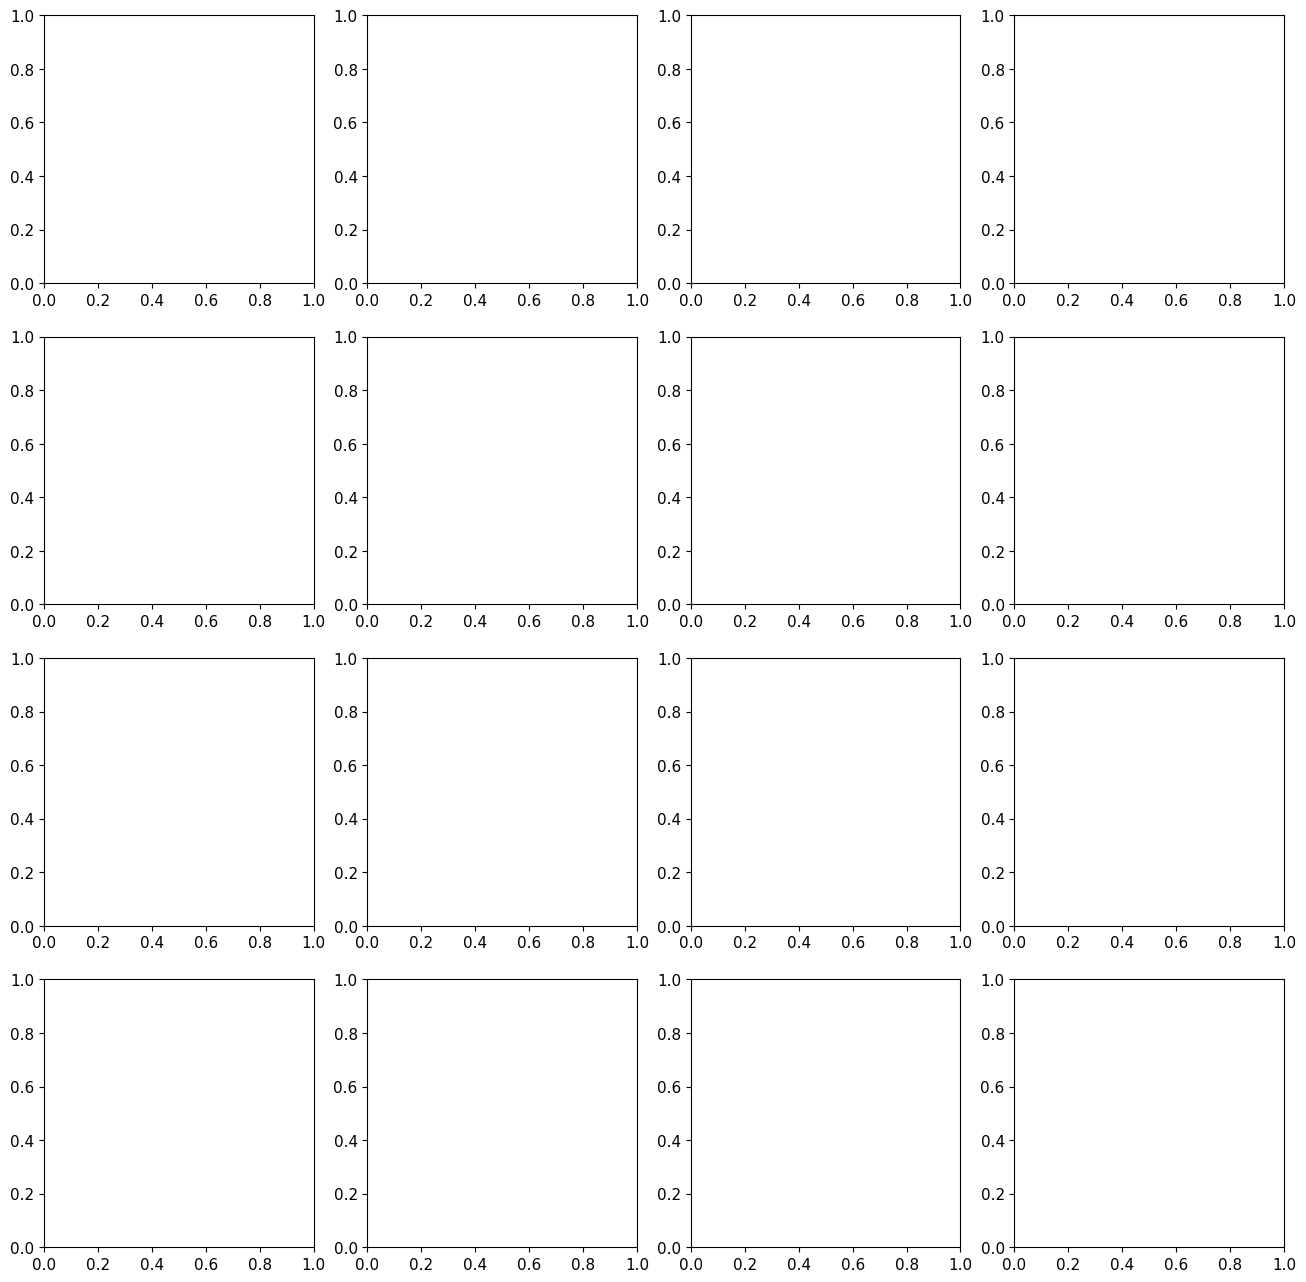

In [48]:
%matplotlib inline
# Fetching random 16 images from test set
test_files = df_test['file'].apply(lambda x: x.replace('annotations','images').replace('xml','png'))
test_images = np.random.choice(test_files, size=(4,4))

# Visualizing predictions
fig, ax = plt.subplots(figsize=(16,16), nrows=4, ncols=4)
for i in range(4):
    for j in range(4):
        # Reading the image
        image = cv2.imread(test_images[i,j])
        # Convert image to RGB colorspace
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Predicting from model
        results = model(image)
        # Getting co ordinates of license plate
        results_df = results.pandas().xyxy[0].loc[0]
        x_min = int(results_df['xmin'])
        x_max = int(results_df['xmax'])
        y_min = int(results_df['ymin'])
        y_max = int(results_df['ymax'])
        # Cropping license plate from image ""
        number_plate = image[y_min:y_max,x_min:x_max]
        # Performing OCR on image
        text = plt.image_to_string(number_plate)
        # Showing the results
        ax[i,j].set_title(str(text).strip())
        ax[i,j].imshow(np.squeeze(results.render()))
plt.show()
